<a href="https://colab.research.google.com/github/nemo0001/Python/blob/master/cardio_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Uploading Dataset

In [4]:
#getting the data from PC

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cardio_train.csv to cardio_train.csv
User uploaded file "cardio_train.csv" with length 2941524 bytes


In [5]:
#After getting abnormal logistic regression values with huge diff. before and after Hyper-Parameter tuning.
#We resorted to removal of irrelavant variable via Corr Matrix, Important Features of Random forest
#We removed normalization since it was creating abnormal results

###Importing Libraries

In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta,Adam
from tensorflow.keras.layers import BatchNormalization,LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import scipy.stats as stats
import sklearn
import os
from sklearn.preprocessing import normalize

#Importing Models
import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#Optimization and Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix,classification_report
%matplotlib inline
import matplotlib.pyplot as plt


In [7]:
data_raw=pd.read_csv("cardio_train.csv",sep=";")
data_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


###Preliminary Data Processing

In [9]:
data_raw.drop("id",axis=1,inplace=True)

In [10]:
#handling duplicate values
print("There are {} duplicate values in data frame".format(data_raw.duplicated().sum()))

There are 24 duplicate values in data frame


In [11]:
#We can drop the duplicates because they have no effect on training of model.
#Firstly let us look at the duplicated rows.
duplicated = data_raw[data_raw.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['age', "gender", "height"], ascending= False) 
#sorted the values to see duplication clearly

duplicated.head(2) # Shows us just 1 duplication of 24

#duplicated() method helps in analyzing duplicate values only. 
#It returns a boolean series which is True only for Unique elements.

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2677,22077,1,175,69.0,120,80,1,1,0,0,1,1
45748,22077,1,175,69.0,120,80,1,1,0,0,1,1


In [12]:
data_raw.drop_duplicates(inplace=True)
#Return DataFrame with duplicate rows removed, optionally only considering certain columns.
#keep : {‘first’, ‘last’, False}, default ‘first’

print("There are {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There are 0 duplicated values in data frame


In [13]:
print("There are {} missing values in data frame".format(data_raw.isnull().sum().sum()))

There are 0 missing values in data frame


###VISUALIZATION

In [14]:
#Detecting Outliers 
#Detecting outlier and handling them can increase our accuracy score.
x = data_raw.copy(deep=True)
x.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
#Columns of "age", "height", "weight", "ap_hi", "ap_lo" may have outlier.
#In order to compare them on same scale we need to standardize firstly.
#My Standard Scalar Function
s_list = ["age", "height", "weight", "ap_hi", "ap_lo"]
def standartization(x):
    x_std = x.copy(deep=True)
    for column in s_list:
        x_std[column] = (x_std[column]-x_std[column].mean())/x_std[column].std()
    return x_std 
x_std=standartization(x)
x_std.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.436071,2,0.443399,-0.847978,-0.122181,-0.088254,1,1,0,0,1,0
1,0.307635,1,-1.018016,0.749554,0.072577,-0.035205,3,1,0,0,1,1
2,-0.248017,1,0.078045,-0.709062,0.007658,-0.141303,3,1,0,0,0,1
3,-0.748143,2,0.565184,0.541180,0.137496,0.017844,1,1,0,0,1,1
4,-0.808532,1,-1.018016,-1.264725,-0.187100,-0.194352,1,1,0,0,0,0


In [16]:
#In order to use the multi box graph plot we need to melt out data.
x_melted = pd.melt(frame=x_std, id_vars="cardio", value_vars=s_list, var_name="features", value_name="value", col_level=None)
x_melted

#melt() function is useful to massage a DataFrame into a format where one or more columns are identifier variables, while all other columns, 
#considered measured variables, are unpivoted to the row axis, leaving just two non-identifier columns, variable and value.

,cardio,features,value
0,0,age,-0.436071
1,1,age,0.307635
2,1,age,-0.248017
3,1,age,-0.748143
4,0,age,-0.808532
...,...,...,...
349875,0,ap_lo,-0.088254
349876,1,ap_lo,-0.035205
349877,1,ap_lo,-0.035205
349878,1,ap_lo,-0.088254


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

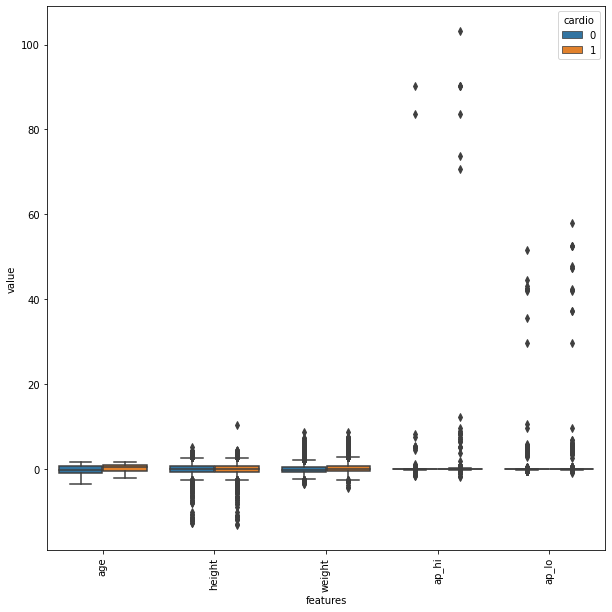

In [17]:
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="cardio", data=x_melted)
plt.xticks(rotation=90)

###Outlier Detection

In [18]:
#There are some outliers in the dataset, but as seen above there is an unusual outlier in ap_hi and ap_lo features.
#Let us calculate the low bound and hi bound of ap_lo and ap_hi features
ap_list = ["ap_hi", "ap_lo","height","weight"]
boundary = pd.DataFrame(index=["lower_bound","upper_bound"]) # We created an empty dataframe
for each in ap_list:
    Q1 = x[each].quantile(0.25)
    Q3 = x[each].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1- 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    boundary[each] = [lower_bound, upper_bound ]
boundary

,ap_hi,ap_lo,height,weight
lower_bound,90.0,65.0,142.5,39.5
upper_bound,170.0,105.0,186.5,107.5


In [19]:
#We can select the index of outlier data by using boundaries we calculated.
ap_hi_filter = (x["ap_hi"] > boundary["ap_hi"][1])
ap_lo_filter = (x["ap_lo"] > boundary["ap_lo"][1])                                                           
outlier_filter = (ap_hi_filter | ap_lo_filter)
x_outliers = x[outlier_filter]
x_outliers["cardio"].value_counts()

1    2025
0     388
Name: cardio, dtype: int64

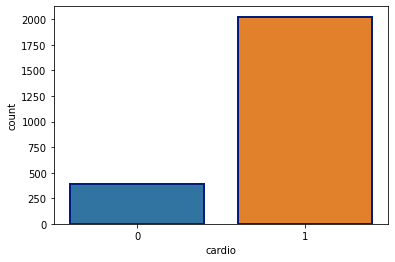

In [20]:
#And I have dropped some of data because we have sufficent data (70000) otherwise I would try to handle them by assigning new values.
sns.countplot(x='cardio',data=x_outliers,linewidth=2,edgecolor=sns.color_palette("dark", 1))

In [21]:
#A study published by doctors in NCBI NLM recorded a maximum blood pressure of 370/360 mm Hg. This study was performed by recording blood pressure in 10 male athletes through radial artery catheterization.
#Thus we can drop the ap_hi outlier values over 250 and ap_lo outlier values over 200, without fear of missing data.
out_filter_bp = ((x["ap_hi"]>250) | (x["ap_lo"]>200) )
print("There are {} outliers".format(x[out_filter_bp]["cardio"].count()))

#We remove lower and higher outliers for height and weight
ht_filter = (x["height"] > boundary["height"][1])
ht_filter_l = (x["height"] < boundary["height"][0])
wt_filter = (x["weight"] > boundary["weight"][1])
wt_filter_l = (x["weight"] < boundary["weight"][0])                                                           
outlier_filter_hw = (ht_filter | wt_filter|ht_filter_l|wt_filter_l)
x_outliers_hw = x[outlier_filter_hw]
x_outliers_hw["cardio"].value_counts()

out_filter_h = ((x["height"] > boundary["height"][1]) | (x["height"] < boundary["height"][0]))
out_filter_w = ((x["weight"] > boundary["weight"][1]) | (x["weight"] < boundary["weight"][0]))
print("There are {} outliers".format(x[out_filter_h]["cardio"].count()))
print("There are {} outliers".format(x[out_filter_w]["cardio"].count()))


There are 993 outliers
There are 519 outliers
There are 1819 outliers


In [22]:
x = x[~out_filter_bp]
x=x[~out_filter_h]
x=x[~out_filter_w]

#Higher diastolic than systolic blood pressure is impossible, too. So let's remove these.
x.drop(x[x["ap_lo"] > x["ap_hi"]].index, inplace=True)
x.drop(x[x["ap_lo"] <= 30].index, inplace=True)
x.drop(x[x["ap_hi"] <= 40].index, inplace=True)
x.drop(x[x["ap_lo"] >= 200].index, inplace=True)
x.drop(x[x["ap_hi"] >= 250].index, inplace=True)

x.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(66459, 12)

###Feature Selection

In [23]:
#Calculating BMI
def bmi_calc(w, h):
    return w/(h**2)
x["bmi"] = x["weight"]/ (x["height"]/100)**2

#Calculating Diff between systolic and diastolic :pulse pressure
x["BP_diff"]=x["ap_hi"]-x["ap_lo"]
x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,BP_diff
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,30
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,50
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40


In [24]:
x["gender"] = x["gender"] % 2

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

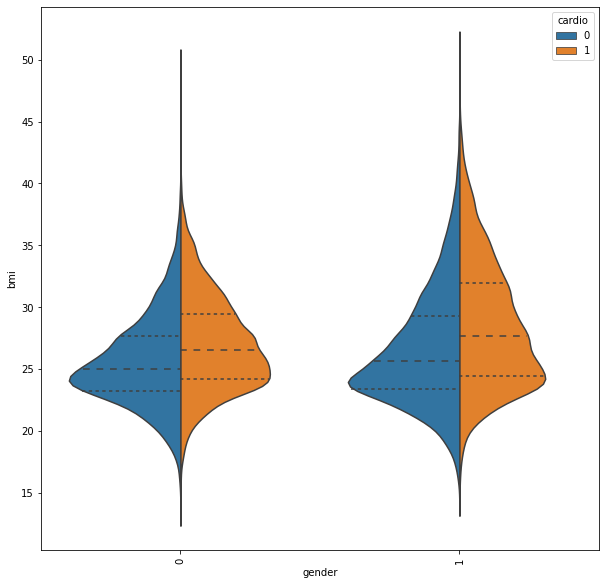

In [25]:
from sklearn.preprocessing import StandardScaler
x_std = standartization(x)

data = pd.melt(x_std,id_vars="cardio",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="gender", y="bmi", hue="cardio", data=x,split=True, inner="quart")
plt.xticks(rotation=90)
#If we interpret the violin plot, the median and quartiles of bmi distribution of patients is slightly higher than non-patients.

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,BP_diff
age,1.000000,0.021335,-0.085890,0.068481,0.213281,0.160724,0.157028,0.098836,-0.044958,-0.027551,-0.011062,0.243087,0.118476,0.174298
gender,0.021335,1.000000,-0.519479,-0.162291,-0.061069,-0.065718,0.038693,0.022920,-0.339302,-0.170253,-0.007178,-0.004527,0.126462,-0.033916
height,-0.085890,-0.519479,1.000000,0.310426,0.009114,0.027818,-0.064388,-0.026080,0.193968,0.094535,-0.007460,-0.019020,-0.237789,-0.009559
weight,0.068481,-0.162291,0.310426,1.000000,0.255413,0.242734,0.130159,0.091228,0.063305,0.064226,-0.015015,0.175799,0.845538,0.167928
ap_hi,0.213281,-0.061069,0.009114,0.255413,1.000000,0.733157,0.193048,0.087781,0.025061,0.032222,0.000865,0.428567,0.255614,0.833799
ap_lo,0.160724,-0.065718,0.027818,0.242734,0.733157,1.000000,0.158147,0.069367,0.023605,0.034183,0.000738,0.338930,0.232288,0.235866
cholesterol,0.157028,0.038693,-0.064388,0.130159,0.193048,0.158147,1.000000,0.449185,0.006794,0.033367,0.009425,0.220301,0.168062,0.147476
gluc,0.098836,0.022920,-0.026080,0.091228,0.087781,0.069367,0.449185,1.000000,-0.009974,0.006446,-0.007052,0.088919,0.107065,0.069125
smoke,-0.044958,-0.339302,0.193968,0.063305,0.025061,0.023605,0.006794,-0.009974,1.000000,0.341654,0.028331,-0.019440,-0.043833,0.016650
alco,-0.027551,-0.170253,0.094535,0.064226,0.032222,0.034183,0.033367,0.006446,0.341654,1.000000,0.026696,-0.010534,0.012037,0.018295


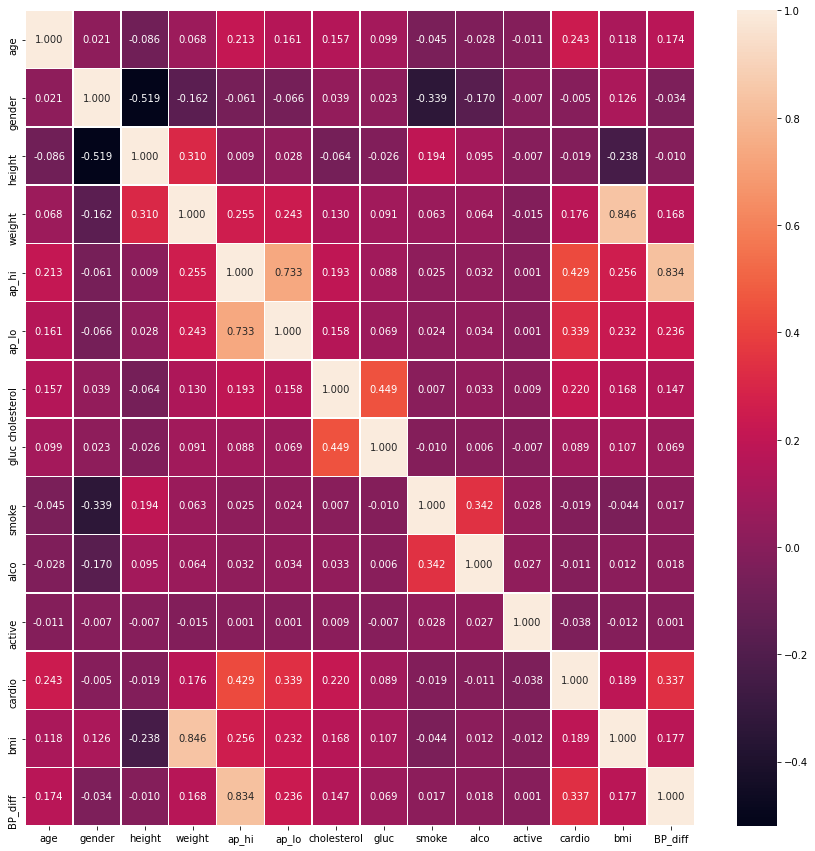

In [26]:

corr = x.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)
corr

#We can see from correlation map easily; cholesterol, blood pressure (ap_hi and ap_low both) and age have a powerful relationship with cardiovascular diseases.
#Glucogen and cholesterol have a strong relationship among them either.

#Smoke , alco ,height and active have low correlation

In [27]:
y = x["cardio"]
y.shape
x.drop(["cardio"], axis=1,inplace=True)

#To check if we have the same percentage of people with CVD in our data.
#Since it's uniform we won't use stratify option in train_test split
sum(y)/len(y)

0.489805744895349

In [28]:
#Significant Features in logit model
import statsmodels.api as sm
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


         Current function value: 0.560398
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.191     
Dependent Variable: cardio           AIC:              74510.9183
Date:               2020-12-01 18:46 BIC:              74620.1704
No. Observations:   66459            Log-Likelihood:   -37243.   
Df Model:           11               LL-Null:          -46052.   
Df Residuals:       66447            LLR p-value:      0.0000    
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
age           0.0001    0.0000   37.1192  0.0000   0.0001   0.0001
gender        0.0103    0.0227    0.4542  0.6497  -0.0341   0.0548
height       -0.0736    0.0008  -93.4497  0.0000  -0.0751  -0.0721
weight        0.0878    0.0019

In [29]:
#train-test split
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
#sum(y_train)/len(y_train)
#sum(y_test)/len(y_test)


In [30]:
#Normalization
# x_train = normalize(x_train)
# x_test = normalize(x_test)

In [31]:
# #Dropping Irrelavant features
# x_train.drop(["smoke"], axis=1,inplace=True)
# x_train.drop(["alco"], axis=1,inplace=True)
# x_train.drop(["height"], axis=1,inplace=True)

# x_test.drop(["smoke"], axis=1,inplace=True)
# x_test.drop(["alco"], axis=1,inplace=True)
# x_test.drop(["height"], axis=1,inplace=True)
# #x_train.drop(["gender"], axis=1,inplace=True)
# x_train.head()

In [32]:
#Using Random forest classifier for feature selection and removal of irrelavant variables.
from sklearn.ensemble import RandomForestClassifier

ran = RandomForestClassifier(n_estimators=100)
ran.fit(x_train, y_train)

# # Saving feature names for later use
feature_list=x_train.columns.values.tolist()
# Get numerical feature importances
importances = list(ran.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: age                  Importance: 0.26
Variable: bmi                  Importance: 0.16
Variable: height               Importance: 0.11
Variable: weight               Importance: 0.11
Variable: ap_hi                Importance: 0.11
Variable: BP_diff              Importance: 0.08
Variable: ap_lo                Importance: 0.06
Variable: cholesterol          Importance: 0.04
Variable: gender               Importance: 0.02
Variable: gluc                 Importance: 0.02
Variable: active               Importance: 0.02
Variable: smoke                Importance: 0.01
Variable: alco                 Importance: 0.01


###Model fitting using RFE

####Logistic Regression

In [58]:
#Using RFE on Logistic Regression, keeping only 7 variables
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg, 1)
rfe = rfe.fit(x_train, y_train)
rank=(rfe.ranking_)
dict_col=dict(zip(feature_list,rank))
dict_col1=sorted(dict_col.items(), key=lambda x: x[1])
dict_col1

[('cholesterol', 1),
 ('active', 2),
 ('smoke', 3),
 ('alco', 4),
 ('gluc', 5),
 ('ap_hi', 6),
 ('bmi', 7),
 ('weight', 8),
 ('height', 9),
 ('ap_lo', 10),
 ('BP_diff', 11),
 ('gender', 12),
 ('age', 13)]

In [61]:
cols=["cholesterol","active","smoke","alco","gluc","ap_hi","bmi"]
x_train_1=x_train[cols]
x_test_1 = x_test[cols]

In [62]:
#Fitting using selected features
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(x_train_1, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
#Evaluation of fitted model
x_test_1 = x_test[cols]
y_pred = logreg.predict(x_test_1)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[5498 1301]
 [2305 4188]]


In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6799
           1       0.76      0.65      0.70      6493

    accuracy                           0.73     13292
   macro avg       0.73      0.73      0.73     13292
weighted avg       0.73      0.73      0.73     13292



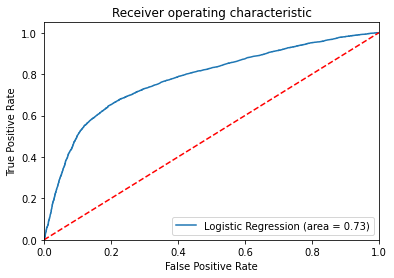

AUC Score 0.7266782399555184


In [75]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test_1))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test_1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
auc = roc_auc_score(y_test, y_pred)
print("AUC Score", auc)

In [71]:
#Optimization and parameter tuning
log_reg = LogisticRegression(solver="liblinear", max_iter=200)
grid = {"penalty" : ["l1", "l2"],
         "C" : np.arange(60,80,2)} # (60,62,64 ... 78)
log_reg_cv = GridSearchCV(logreg, grid, cv=3)
log_reg_cv.fit(x_train_1, y_train)

# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(log_reg_cv.best_params_)) 
print("Best score: {}".format(log_reg_cv.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

Tuned hyperparameter n_estimators: {'C': 76, 'penalty': 'l2'}
Best score: 0.7234375475352627


Test accuracy:  0.7285585314474872
AUC Score 0.7266782399555184


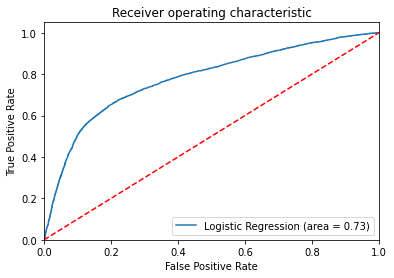

In [74]:
#Test Set Accuracy Score ¶
#Now we have selected our model with better hyper parameters than default ones.
#It is time to evaluate model with our test set
logreg_best = LogisticRegression(C=76, penalty="l2", solver="liblinear")
logreg_best.fit(x_train_1, y_train)
print("Test accuracy: ",logreg_best.score(x_test_1, y_test))

y_pred = logreg_best.predict(x_test_1)
# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("AUC Score", auc)

logit_roc_auc = roc_auc_score(y_test, logreg_best.predict(x_test_1))
fpr, tpr, thresholds = roc_curve(y_test, logreg_best.predict_proba(x_test_1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Decision tree
Accuracy Score 0.6593439662955161
AUC Score 0.6569764213928146


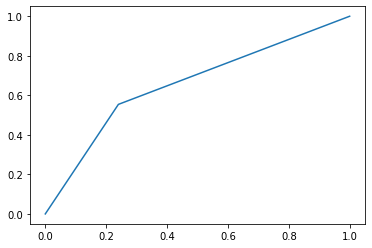

Random forest
Accuracy Score 0.6718326813120674
AUC Score 0.6703208748208526


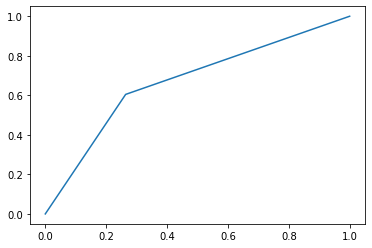

KNN
Accuracy Score 0.7263767679807402
AUC Score 0.7243826817285689


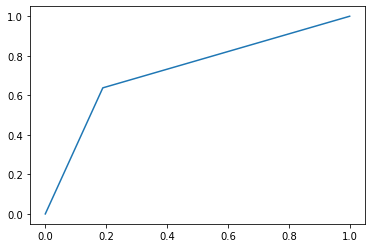

SVM
Accuracy Score 0.7123833885043636
AUC Score 0.7087183076791241


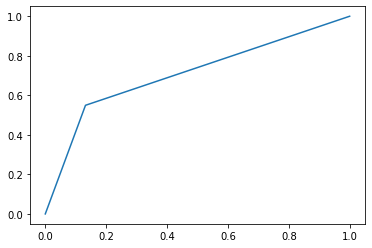

Naive bayes
Accuracy Score 0.6982395425820042
AUC Score 0.6952913097923212


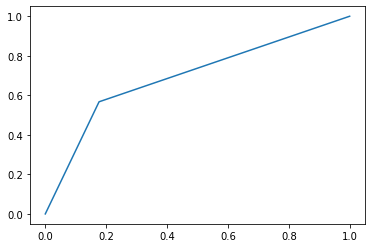

In [123]:
dec = DecisionTreeClassifier()
ran = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
svm = SVC(random_state=1)
naive = GaussianNB()

#models to be fitted
#later part added AUC scores and plots for better evaluation
models = {"Decision tree" : dec,
          "Random forest" : ran,
          "KNN" : knn,
          "SVM" : svm,
          "Naive bayes" : naive,
         }
scores= { }
auc={ }

for key, value in models.items():    
    model = value
    model.fit(x_train_1, y_train)
    scores[key] = model.score(x_test_1, y_test)
    print(key)
    print("Accuracy Score", scores[key])

    y_pred = model.predict(x_test_1)

    tpr, fpr, threshold = roc_curve(y_test, y_pred)
    auc[key] = roc_auc_score(y_test, y_pred)
    print("AUC Score", auc[key])

    plt.plot(tpr, fpr)
    plt.show()


In [127]:
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

,Accuracy Score
KNN,0.726377
SVM,0.712383
Naive bayes,0.698240
Random forest,0.671833
Decision tree,0.659344


In [125]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

AUC-score: 0.7286026312699838


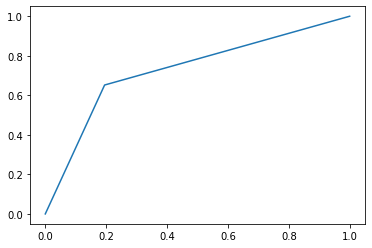

In [129]:
#XGBoost simple model fit

xgb_clf = XGBClassifier()
xgb_clf.fit(x_train_1, y_train)

#print_score(xgb_clf, x_train_1, y_train, x_test_1, y_test, train=True)
#print_score(xgb_clf, x_train_1, y_train, x_test_1, y_test, train=False)

y_pred = xgb_clf.predict(x_test_1)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-score:", auc_score)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(tpr, fpr)
plt.show()